In [ ]:
install.packages("igraph")
library('igraph')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




**2. Personalized network**

In [ ]:
# input the original network from facebook combined 
fNetwork <- read.graph("facebook_combined.txt", format = "edgelist", directed=FALSE)

QUESTION 5: Create a personalized network of the user whose ID is 1. How many nodes and edges does this personalized network have?

[1] "the number of nodes in the personalized network =  348"
[1] "the number of edges in the personalized network =  2866"


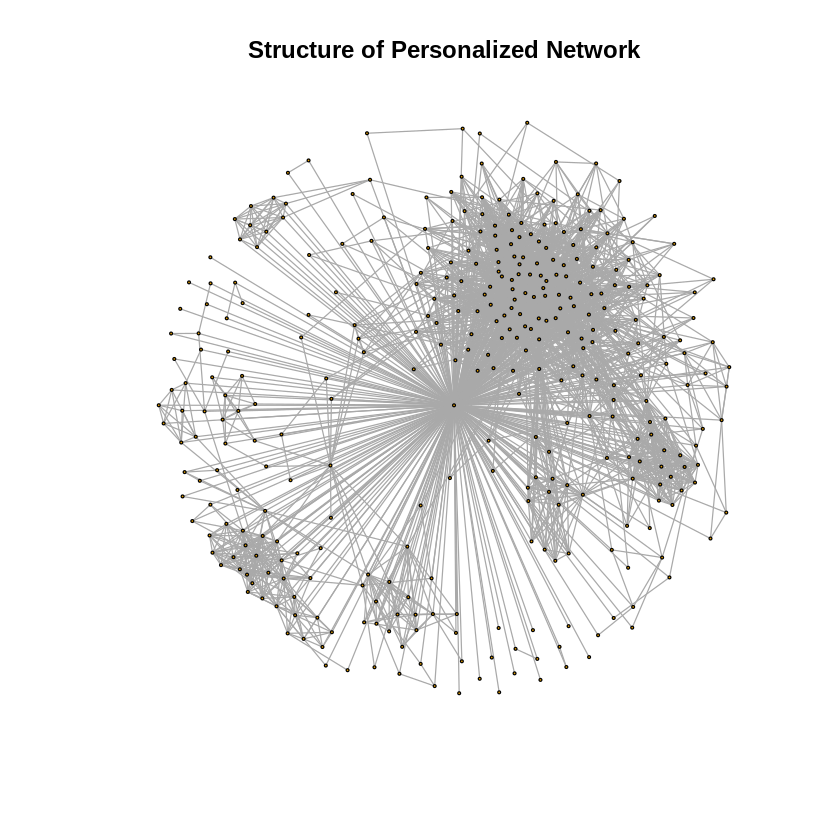

In [ ]:
# generate a personalize network of the user whose ID is 1
pNetwork <- make_ego_graph(fNetwork, order = 1, nodes = V(fNetwork))[[1]]

# plot the structure of the personalize network
plot(pNetwork, vertex.size = 1, vertex.label = NA,  main = "Structure of Personalized Network")

# calculate the number of nodes in this personalized network
pNetworknodes = gorder(pNetwork)

# print the number of the nodes in this personalized netwrok
print(paste("the number of nodes in the personalized network = ",pNetworknodes))

# calculate the number of edges in this personalized network
pNetworkedges = gsize(pNetwork)

# print the number of the edges in this personalized netwrok
print(paste("the number of edges in the personalized network = ", pNetworkedges))


QUESTION 6: What is the diameter of the personalized network? Please state a trivial upper and lower bound for the diameter of the personalized network

In [ ]:
# calculate the diameter of the personalized network
diameterNet = diameter(pNetwork)

# print the diameter of the personalized netwrok
print(paste("the diameter of the personalized network = ", diameterNet))

[1] "the diameter of the personalized network =  2"


The trivial lower bound for the diameter of a personalized network could be 0, when there is only one user in the network. For other network with multiple users, the lower bound could be 1 and the upper bound could be 2. The lower bound is 1, when all component connect with each other simultaneously. The upper bound is 2, because all the nodes connect to the center vertex.

**4. Friend recommendation in personalized networks**

  QUESTION 16: What is |Nr|, i.e. the length of the list Nr?

In [ ]:
# generate a personalize network of the user whose ID is 415
V(fNetwork)$name <- V(fNetwork)
pNetwork <- induced_subgraph(fNetwork, c(415,neighbors(fNetwork,415)))

# obtian the list Nr, where nodes with degree 24
Nr <- as.numeric(which(degree(pNetwork) == 24))

# print the length of the list Nr
print(paste("the length of the list Nr = ", length(Nr)))

[1] "the length of the list Nr =  11"


QUESTION 17: Compute the average accuracy of the friend recommendation algorithm that uses:

• Common Neighbors measure

• Jaccard measure

• Adamic Adar measure

Common neighbor measure function

In [ ]:
CommonNeighborMeasure <- function(network, nodei, nodej)
{
  return(length(intersect(neighbors(network, nodei),neighbors(network, nodej))))
}

Jaccard measure function

In [ ]:
JaccardMeasure <- function(network, nodei, nodej)
{
  denominator = length(union(neighbors(network, nodei),neighbors(network, nodej)))
  numerator = length(intersect(neighbors(network, nodei),neighbors(network, nodej)))
  return(numerator/denominator)
}

Adamic-Adar measure function

In [ ]:
AdamicAdarMeasure <- function(network, nodei, nodej)
{
  returnNum = 0
  neighborIntersection = intersect(neighbors(network, nodei),neighbors(network, nodej))
  for (component in neighborIntersection)
  {
    returnNum = returnNum + 1/log(length(neighbors(network,component)))
  }
  return(returnNum)
}

Function of caculate the score for each node being recommend as a friend based on different neighbor measure

In [ ]:
calculate_single_node_value <- function (network, nodei, method) 
{
  # delete the some friends of node i (deleting the network)
  tempNetwork <- network
  deleteFriend <- c()
  while (length(deleteFriend) == 0) 
  {
    for (node in as.numeric(neighbors(tempNetwork, nodei))) 
    {
      if (runif(1,0,1) <= 0.25) 
      {
        # delete the friends of node i
        tempNetwork <- delete_edges(tempNetwork, get.edge.ids(tempNetwork,c(nodei,node)))
         
        # form a new network which contain the friend of node i        
        deleteFriend <- c(deleteFriend, node)
      }
    }
  }  
  # obtain the size of the deleteFriend network
  deletedSize = length(deleteFriend)

  # obtain the potential friend
  potentialFriend <- setdiff(V(tempNetwork), c(as.numeric(neighbors(tempNetwork, nodei)), nodei))
  
  # initialize the network for the value of different node
  valueList <- c()

  # caculate the value of each node
  for (friend in potentialFriend) 
  {
    # initialize the value for each potential friend
    tempValue = 0
    if (method == "CommonNeighborMeasure") 
    {
      tempValue <- (CommonNeighborMeasure(tempNetwork, nodei, friend))
    } 
    else if (method == "JaccardMeasure") 
    {
      tempValue <- (JaccardMeasure(tempNetwork, nodei, friend))
    } 
    else if (method == "AdamicAdarMeasure") 
    {
      tempValue <- (AdamicAdarMeasure(tempNetwork, nodei, friend))
    }
    valueList <- c(valueList, tempValue)
  }  
  
  # obtain the friend  
  friends = potentialFriend[sort(valueList, decreasing=TRUE, index.return=TRUE)$ix[1:deletedSize]]
    
  return (length(intersect(friends, deleteFriend))/length(deleteFriend))
}


In [ ]:
# generate the frame to collect the value of each potential friends' value
valueList <- data.frame()
for (method in c("CommonNeighborMeasure", "JaccardMeasure", "AdamicAdarMeasure"))
{   
    for (nodei in Nr)
    {
      tempValue = 0
      for (num in 1:10) 
      {
        tempValue = tempValue + calculate_single_node_value(pNetwork, nodei, method)
      }
      aveValue = tempValue/10
      valueList[toString(V(pNetwork)[nodei]$name), method] <- aveValue
    }
}
aveMethod <- colSums(valueList)/11
valueList
aveMethod

,CommonNeighborMeasure,JaccardMeasure,AdamicAdarMeasure
,<dbl>,<dbl>,<dbl>
497,0.3276190,0.2078571,0.3952381
579,0.9732143,0.9833333,1.0000000
601,0.8747619,0.9073810,0.8498810
616,0.8304365,0.8096032,0.8409091
619,0.3799603,0.5277633,0.4422619
628,1.0000000,0.9383333,0.9900000
644,0.9100000,0.8563889,0.8774567
659,0.9750000,0.9350000,1.0000000
660,0.9857143,0.9210317,0.9800000


CommonNeighborMeasure        JaccardMeasure     AdamicAdarMeasure 
            0.8331494             0.8137105             0.8344005

**2. Google+ network**

QUESTION 18: How many personal networks are there?

In [ ]:
# obtain the file end with '.circle' with the path to the circle of each node
fileCircle = list.files(path = "gplus_circles/", pattern = "circles")

# initialize the personal network
personalNet = 0

# count the personal network
for(tempnode in fileCircle)
{
  filePath = paste(path = "gplus_circles/", tempnode, sep="")
  if(length(readLines(filePath))>2)
  {
    personalNet = personalNet + 1
  }
}

# print the number of the personal network
print(paste("the number of the personal network = ", personalNet))


[1] "the number of the personal network =  0"


QUESTION 19: For the 3 personal networks (node ID given below), plot the in-degree and outdegree distribution of these personal networks. Do the personal networks have a similar in and out
degree distribution? In this question, you should have 6 plots.

• 109327480479767108490

• 115625564993990145546

• 101373961279443806744

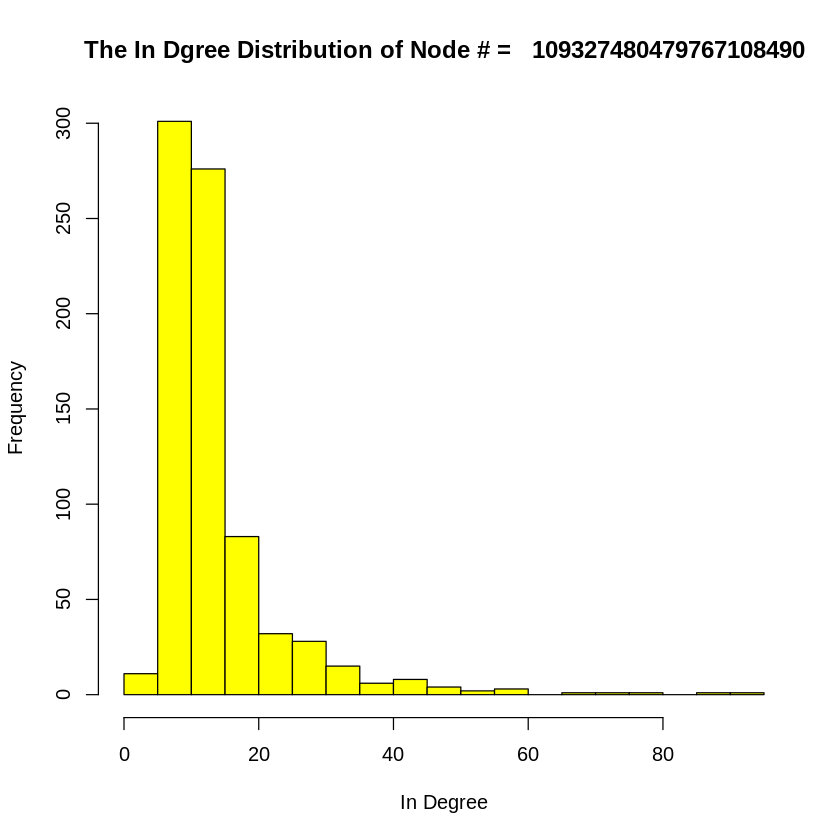

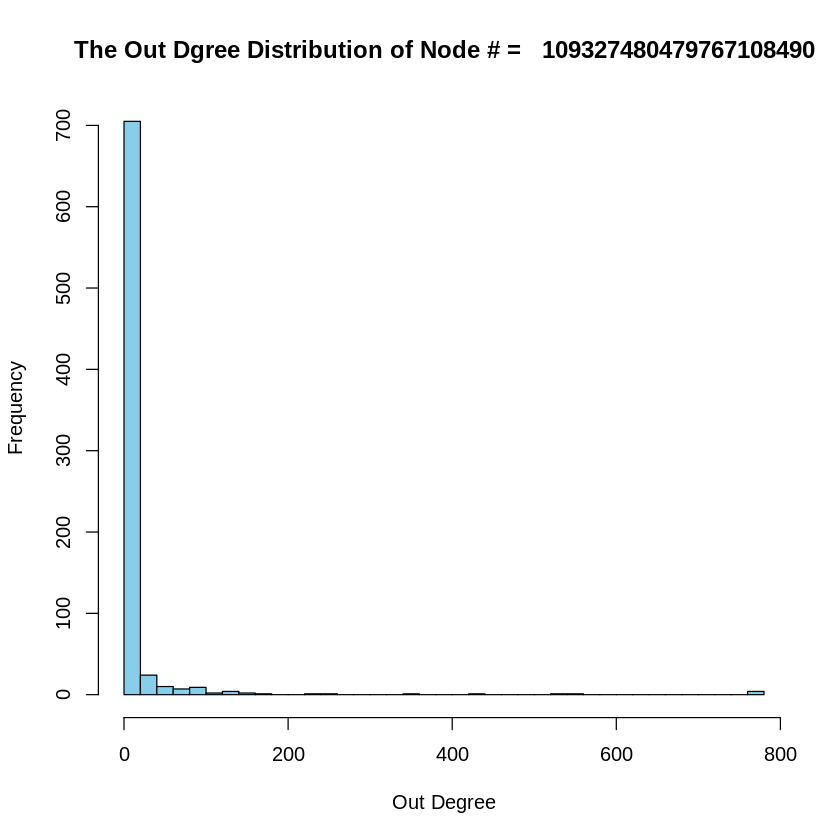

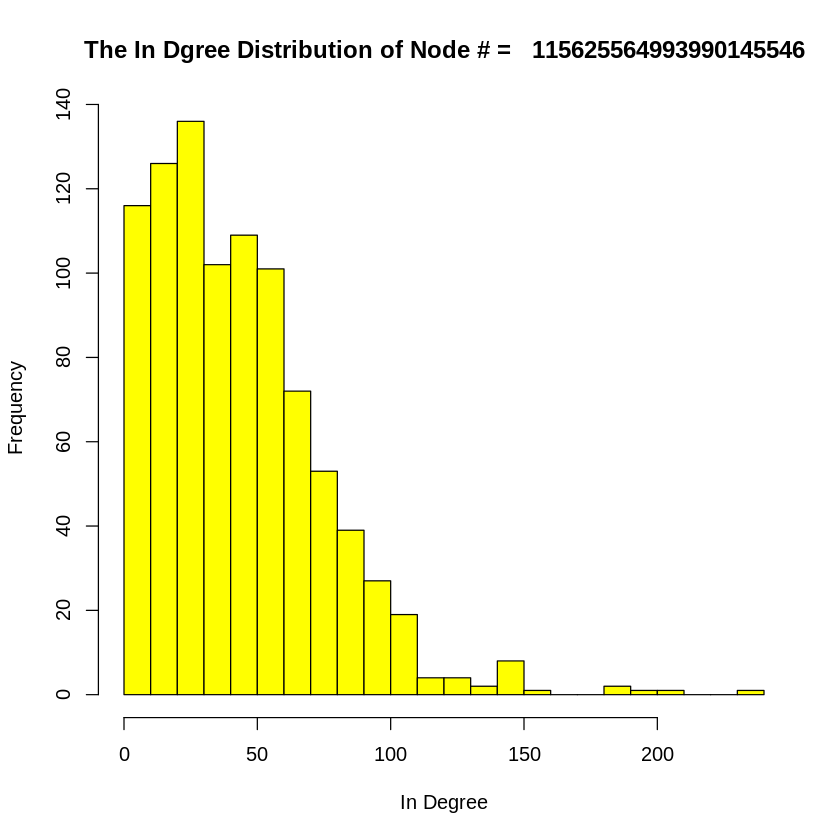

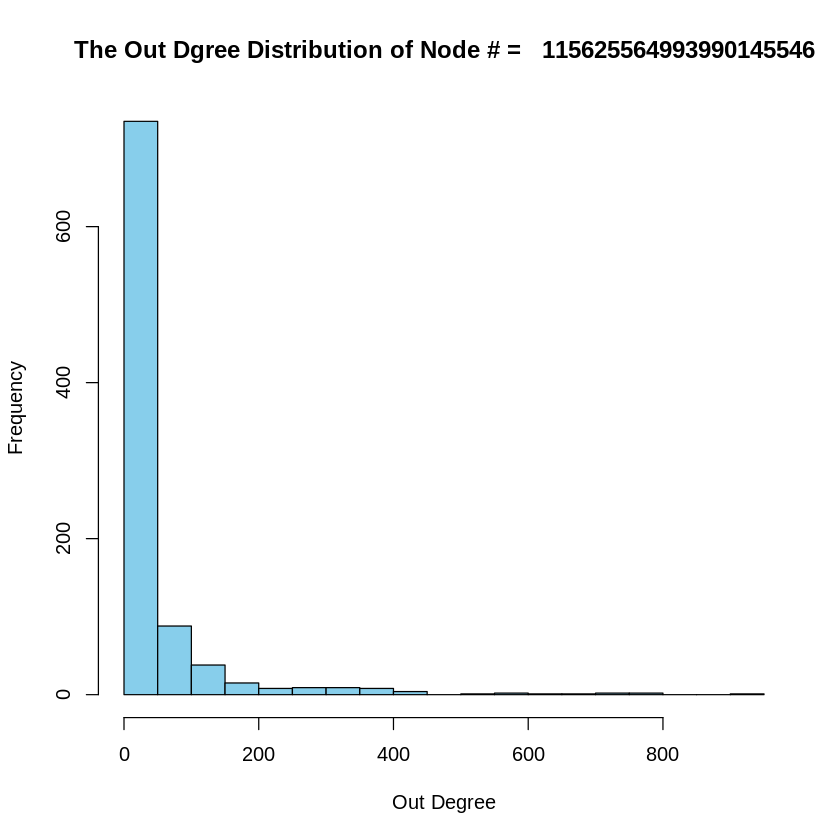

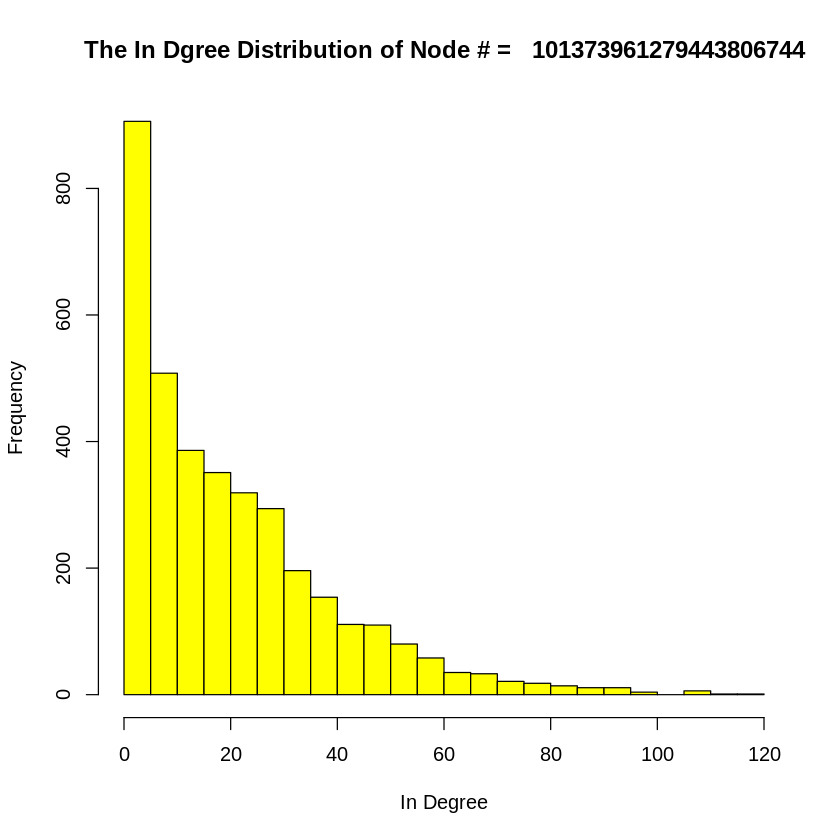

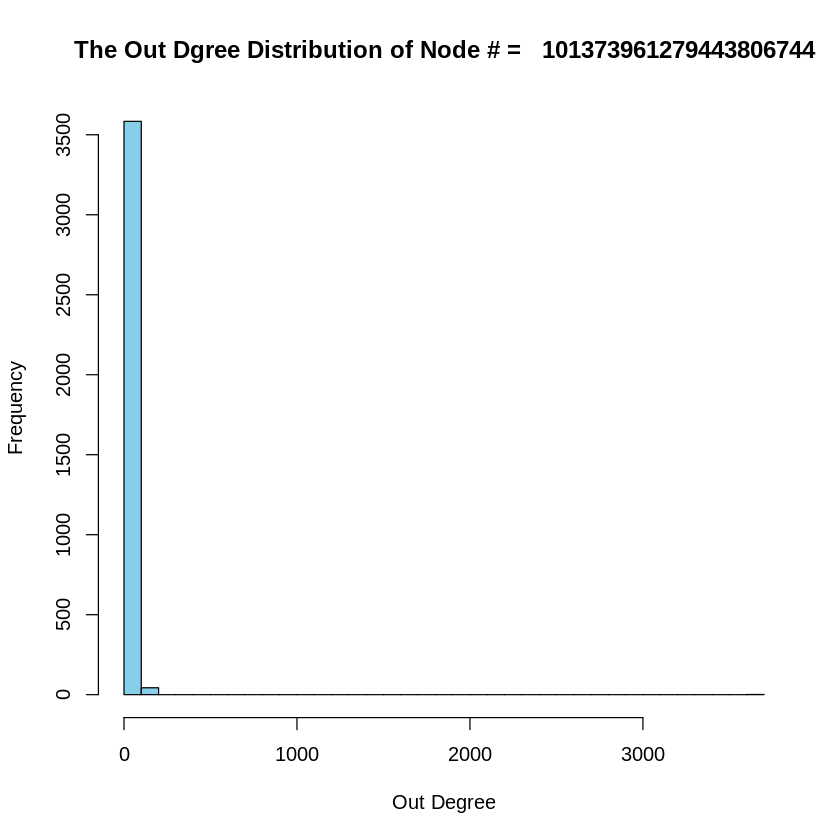

In [ ]:
# obtain the target nodes' ID
nodeIDlist <- c("109327480479767108490","115625564993990145546","101373961279443806744")

# scan the target node's ID from ID list
for(nodeID in nodeIDlist)
{
  # initialize the personal circles for each target ID
  personalCircle <- list()

  # obtain the circle of the corresponding node
  circlePath = paste(path = "gplus_ID/", nodeID, ".circles", sep = "")

  # obtain the lines of the circle
  circleLine = readLines(circlePath)

  # obtain the circle of the corresponding node
  for(pos in 1:length(circleLine))
  {
    tempCircle = strsplit(circleLine[pos], "\t")
    personalCircle[[pos]] = tempCircle[[1]][-1]
  }
   
  # obtain the network of a node with more than 2 circle which from the defination is the communication
  if(length(personalCircle) > 2)
  {
    # obtain the edge of the corresponding node
    egdePath = paste(path = "gplus_ID/", nodeID, ".edges", sep = "")

    # obtain the network
    tempNetwork = read.graph(egdePath, format = "ncol", directed = TRUE)

    # add node in to the network
    tempNetwork = add.vertices(tempNetwork, nv = 1, name = nodeID)

    # initialize the edge of the node
    nodeEdge <- c()

    # obtain the number of the node in the network
    numNode = vcount(tempNetwork)

    for(pos in 1:(numNode - 1))
    {
      # initialize the edge of the node with corresponding number
      nodeEdge <- c(nodeEdge, c(numNode, pos))
    }

    # add edge to the network
    tempNetwork = add.edges(tempNetwork, nodeEdge)
  }

  # obtain the network
  network = list("circles"=personalCircle, "graph"=tempNetwork)$graph
  
  # plot the in degree
  hist(degree(network, mode="in"), main=paste("The In Dgree Distribution of Node # =  ", nodeID), xlab="In Degree", ylab="Frequency", breaks=30, col = "yellow")
  hist(degree(network, mode="out"), main=paste("The Out Dgree Distribution of Node # =  ", nodeID), xlab="Out Degree", ylab="Frequency", breaks=30, col = "skyblue")


}


QUESTION 20: For the 3 personal networks picked in Question 19, extract the community structure of each personal network using Walktrap community detection algorithm. Report the modularity scores and plot the communities using colors. Are the modularity scores similar? In this question, you should have 3 plots

[1] "the modularity of 109327480479767108490  ID =  0.25276535939251"
[1] "the modularity of 115625564993990145546  ID =  0.319472554647349"


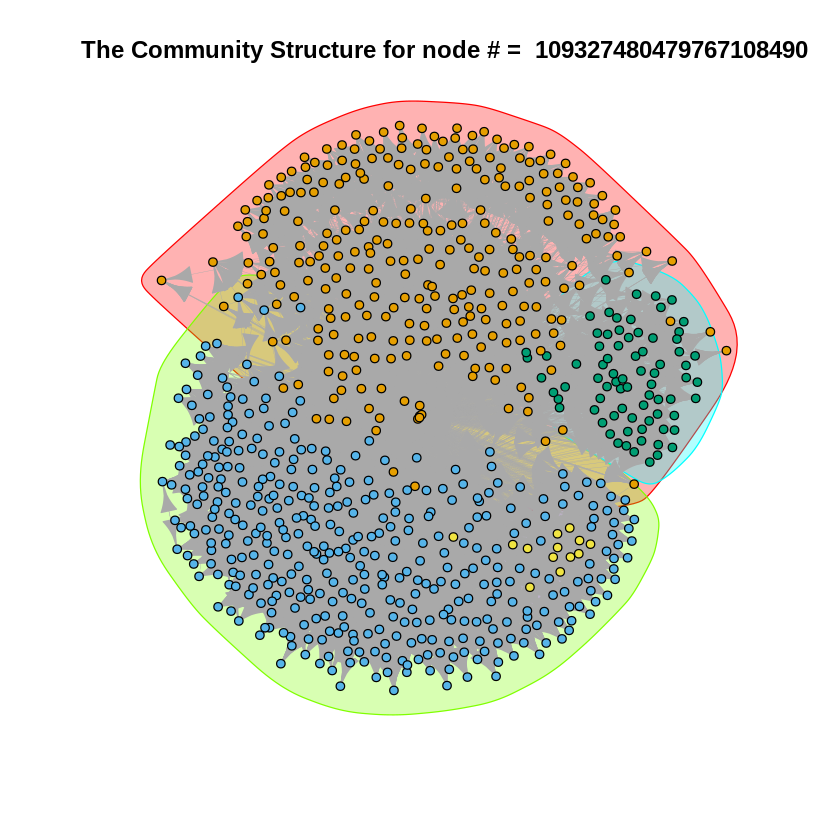

[1] "the modularity of 101373961279443806744  ID =  0.195562434304441"


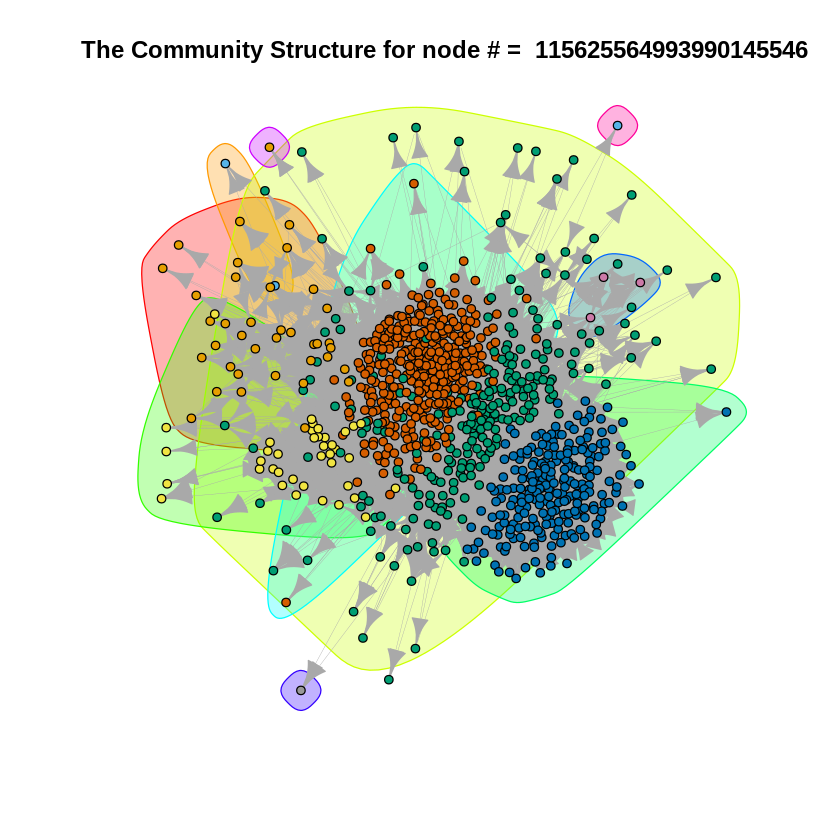

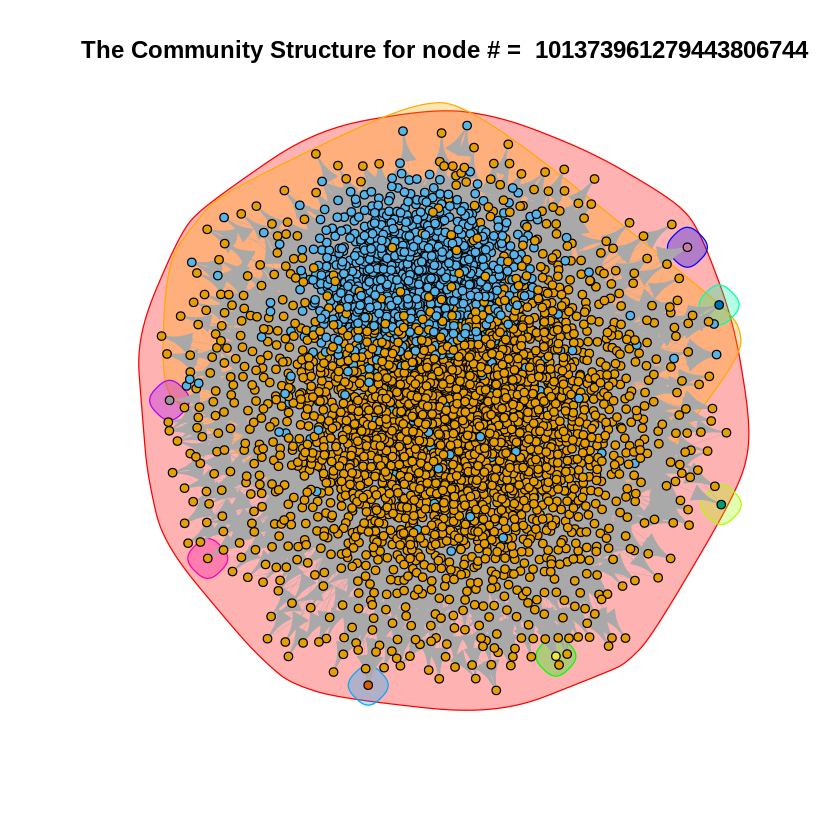

In [ ]:
# scan the target node's ID from ID list
for(nodeID in nodeIDlist)
{
  # initialize the personal circles for each target ID
  personalCircle <- list()

  # obtain the circle of the corresponding node
  circlePath = paste(path = "gplus_ID/", nodeID, ".circles", sep = "")

  # obtain the lines of the circle
  circleLine = readLines(circlePath)

  # obtain the circle of the corresponding node
  for(pos in 1:length(circleLine))
  {
    tempCircle = strsplit(circleLine[pos], "\t")
    personalCircle[[pos]] = tempCircle[[1]][-1]
  }
   
  # obtain the network of a node with more than 2 circle which from the defination is the communication
  if(length(personalCircle) > 2)
  {
    # obtain the edge of the corresponding node
    egdePath = paste(path = "gplus_ID/", nodeID, ".edges", sep = "")

    # obtain the network
    tempNetwork = read.graph(egdePath, format = "ncol", directed = TRUE)

    # add node in to the network
    tempNetwork = add.vertices(tempNetwork, nv = 1, name = nodeID)

    # initialize the edge of the node
    nodeEdge <- c()

    # obtain the number of the node in the network
    numNode = vcount(tempNetwork)

    for(pos in 1:(numNode - 1))
    {
      # initialize the edge of the node with corresponding number
      nodeEdge <- c(nodeEdge, c(numNode, pos))
    }

    # add edge to the network
    tempNetwork = add.edges(tempNetwork, nodeEdge)
  }

  # obtain the network
  network = list("circles"=personalCircle, "graph"=tempNetwork)$graph

  # obtain the communities for corresponding network
  communities = cluster_walktrap(network)

  # obtain the modularity of the communities
  modularities  = modularity(communities)

  # print the value of the modularity
  print(paste("the modularity of",nodeID ," ID = ", modularities))

  # plot the whole network and community structure
  plot(network, mark.groups = communities, edge.width = 0.3, vertex.size = 3, vertex.color = communities$membership, vertex.label = "", main=paste("The Community Structure for node # = ", nodeID))

}

QUESTION 22: Compute the h and c values for the community structures of the 3 personal network (same nodes as Question 19). Interpret the values and provide a detailed explanation. Are there negative values? Why?

In [ ]:
# scan the target node's ID from ID list
for(nodeID in nodeIDlist)
{
  # initialize the personal circles for each target ID
  personalCircle <- list()

  # obtain the circle of the corresponding node
  circlePath = paste(path = "gplus_ID/", nodeID, ".circles", sep = "")

  # obtain the lines of the circle
  circleLine = readLines(circlePath)

  # obtain the circle of the corresponding node
  for(pos in 1:length(circleLine))
  {
    tempCircle = strsplit(circleLine[pos], "\t")
    personalCircle[[pos]] = tempCircle[[1]][-1]
  }
   
  # obtain the network of a node with more than 2 circle which from the defination is the communication
  if(length(personalCircle) > 2)
  {
    # obtain the edge of the corresponding node
    egdePath = paste(path = "gplus_ID/", nodeID, ".edges", sep = "")

    # obtain the network
    tempNetwork = read.graph(egdePath, format = "ncol", directed = TRUE)

    # add node in to the network
    tempNetwork = add.vertices(tempNetwork, nv = 1, name = nodeID)

    # initialize the edge of the node
    nodeEdge <- c()

    # obtain the number of the node in the network
    numNode = vcount(tempNetwork)

    for(pos in 1:(numNode - 1))
    {
      # initialize the edge of the node with corresponding number
      nodeEdge <- c(nodeEdge, c(numNode, pos))
    }

    # add edge to the network
    tempNetwork = add.edges(tempNetwork, nodeEdge)
  }

  # obtain the network
  network = list("circles"=personalCircle, "graph"=tempNetwork)$graph

  # obtain the community of the corresponding network
  communities = cluster_walktrap(network)
  
  # obtain the circle of the network
  circleNetwork = list("circles"=personalCircle, "graph"=tempNetwork)$circles

  # calculate the total number of people with circle information
  totalCircle = unique(c(unlist(circleNetwork)))
  totalNum = length(totalCircle)

  # cacluate the H(C) C is the set of circles
  # initialize the H(C)
  HC = 0
  for(tempcircle in circleNetwork)
  {
    ai = length(tempcircle)
    HC = HC - ((ai/totalNum)*log10(ai/totalNum))
  }

  # cacluate the H(K) K is the set of communities
  # initialize the H(K)  
  HK = 0
  for(posi in 1:length(communities))
  {
    communityNodes = communities[[posi]]
    bi = length(intersect(communityNodes, totalCircle))
    if(bi != 0)
    {
      HK = HK - ((bi/totalNum)*log10(bi/totalNum))
    }
  }

  # calculate the H(C|K)
  # initialize the H(C|K)
  HCK = 0
  for(posj in 1:length(communities))
  {
    communityNodes = communities[[posj]]
    bj = length(intersect(communityNodes, totalCircle))
    if(bj != 0)
    {
      for(posi in 1:length(circleNetwork))
      {
        circleNodes = circleNetwork[[posi]]
        Aji = length(unique(intersect(communityNodes, circleNodes)))
        if(Aji != 0)
        {
          HCK = HCK - ((Aji/totalNum)*log10(Aji/bj))
        }
      }
    }  
  }

  # calculate the H(K|C)
  # initialize the H(K|C)
  HKC = 0
  for(posi in 1:length(circleNetwork))
  {
    circleNodes = circleNetwork[[posi]]
    ai = length(circleNodes)
    if(ai != 0)
    {
      for(posj in 1:length(communities))
      {
        communityNodes = communities[[posj]]
        Aij = length(unique(intersect(communityNodes, circleNodes)))
        if(Aij != 0)
        {
          HKC = HKC - ((Aij/totalNum)*log10(Aij/ai))
        }
      }
    }  
  }
  # Calculate homogenity, completeness and V-measure
    h = 1 - (HCK / HC)
    c = 1 - (HKC / HK)
    v = 2 * (h * c) / (h + c)
    
    print(paste("Node ID: %s", nodeID))
    print(paste("Entropy H(C) = %5.10f", HC))
    print(paste("Entropy H(K) = %5.10f", HK))
    print(paste("Conditional Entropy H(C|K) = %5.10f", HCK))
    print(paste("Conditional Entropy H(K|C) = %5.10f", HKC)) 
    print(paste("Homogeneity h= %5.10f", h))
    print(paste("Completeness c= %5.10f", c))    
    print(paste("V-measure V= %5.10f", v))
    cat("\n")
}

[1] "Node ID: %s 109327480479767108490"
[1] "Entropy H(C) = %5.10f 0.45634767235013"
[1] "Entropy H(K) = %5.10f 0.436556366124568"
[1] "Conditional Entropy H(C|K) = %5.10f 0.0675918828089686"
[1] "Conditional Entropy H(K|C) = %5.10f 0.292547809151702"
[1] "Homogeneity h= %5.10f 0.851885115440867"
[1] "Completeness c= %5.10f 0.329873913536689"
[1] "V-measure V= %5.10f 0.47558710367081"

[1] "Node ID: %s 115625564993990145546"
[1] "Entropy H(C) = %5.10f 3.67636649231724"
[1] "Entropy H(K) = %5.10f 0.469555269367908"
[1] "Conditional Entropy H(C|K) = %5.10f 2.01505212404645"
[1] "Conditional Entropy H(K|C) = %5.10f 2.07729483251062"
[1] "Homogeneity h= %5.10f 0.451890303032235"
[1] "Completeness c= %5.10f -3.4239623491117"
[1] "V-measure V= %5.10f 1.04119641753104"

[1] "Node ID: %s 101373961279443806744"
[1] "Entropy H(C) = %5.10f 0.166908037462021"
[1] "Entropy H(K) = %5.10f 0.277918666551478"
[1] "Conditional Entropy H(C|K) = %5.10f 0.166622391231686"
[1] "Conditional Entropy H(K|C) = 

In [ ]:
install.packages("ggplot2")
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



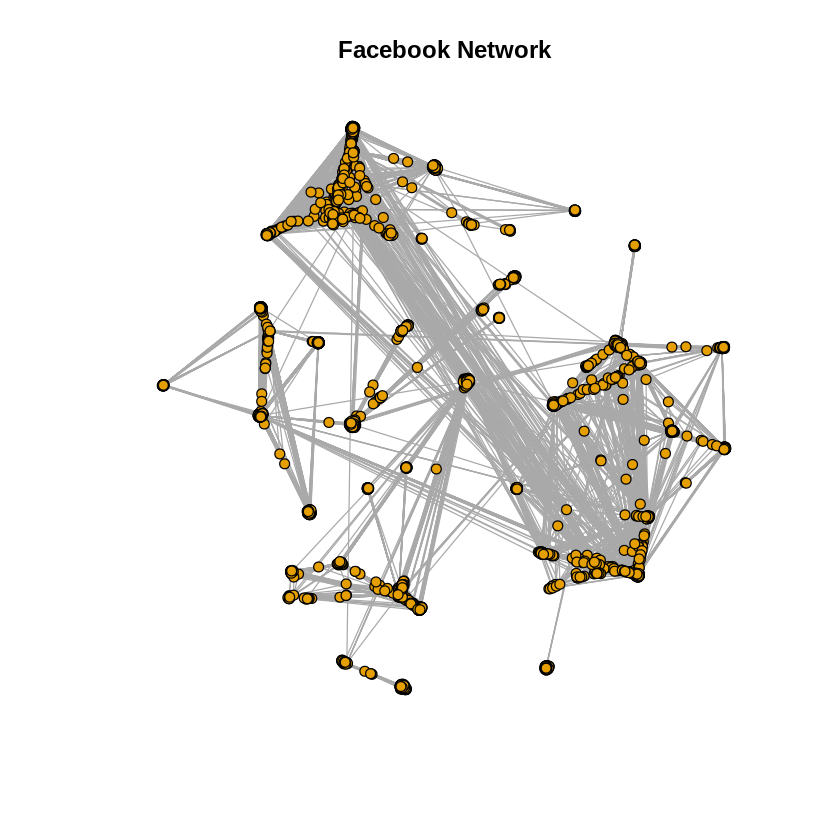

In [ ]:
fbgraph <- read.graph("facebook_combined.txt",directed=F)
plot(fbgraph, vertex.size=3.5, vertex.label=NA, main="Facebook Network")

In [ ]:
vcount(fbgraph)#node
ecount(fbgraph)#edge

[1] 4039

[1] 88234

In [ ]:
is.connected(fbgraph)

[1] TRUE

In [ ]:
diameter(fbgraph)

[1] 8

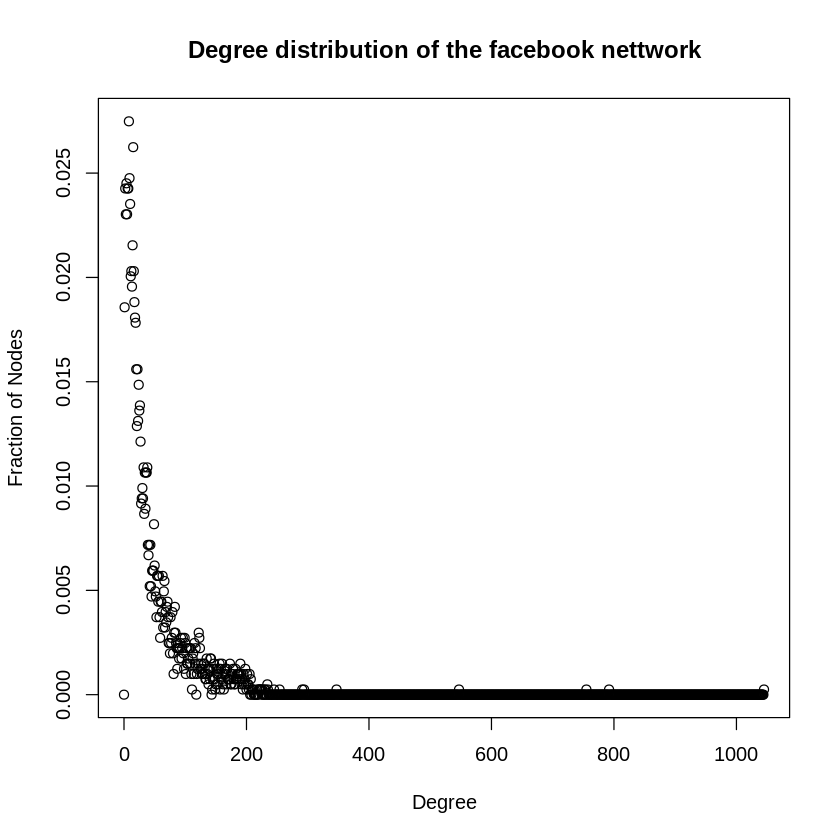

In [ ]:
frequency <- degree.distribution(fbgraph)
degree <- seq_along(degree.distribution(fbgraph)) - 1
plot(degree, frequency, xlab="Degree", ylab="Fraction of Nodes", main ="Degree distribution of the facebook nettwork")

In [ ]:
mean(degree(fbgraph)) # the average degree

[1] 43.69101

The slope of the plot is -1.180164

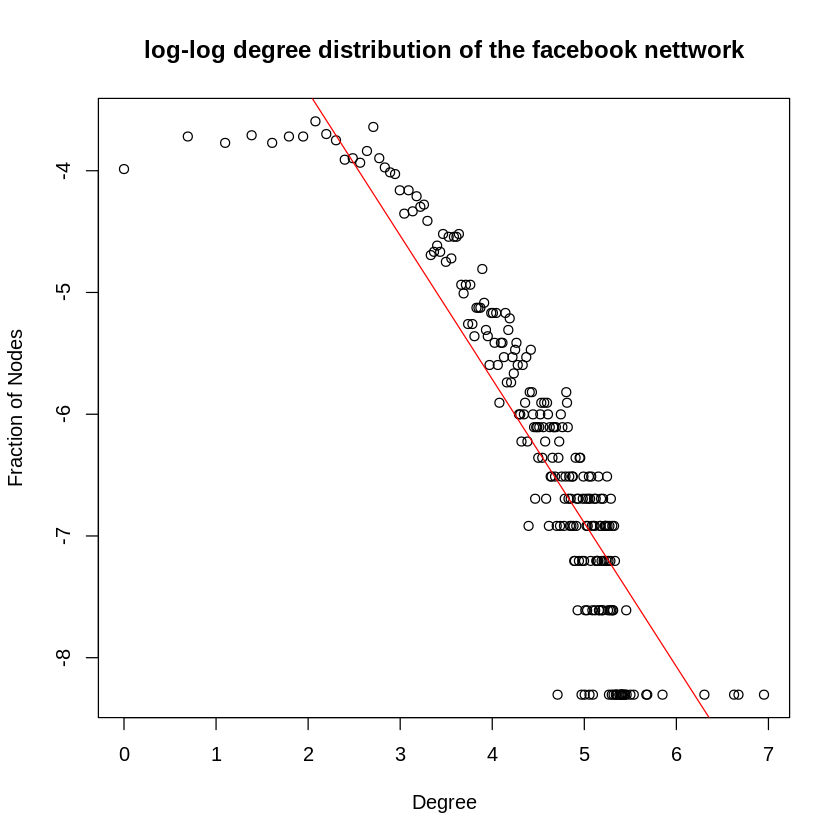

In [ ]:
log_fre <- log(frequency)
log_deg <- log(degree)

plot(log_deg, log_fre, xlab="Degree", ylab="Fraction of Nodes", main ="log-log degree distribution of the facebook nettwork")
# here we need to eliminat some invalid value in distri
invalid_idx <- is.infinite(log_fre)
# create a data frame for linear regression
ndata <- data.frame(x=log_deg, y=log_fre)[!invalid_idx,]
# linear regression
model <- lm(y~x, ndata)
abline(model, col='red')
slope <- coef(model)[2]
cat("The slope of the plot is", slope)

In [ ]:
# Calculate the degree of each node
node_degrees <- degree(fbgraph)

# Identify the core nodes
core_nodes <- which(node_degrees > 200)

# Get the number of core nodes
num_core_nodes <- length(core_nodes)

# Print the core nodes and the number of them
print(paste("Core Nodes:", paste(core_nodes, collapse=", ")))
print(paste("Number of Core Nodes:", num_core_nodes))

[1] "Core Nodes: 1, 108, 349, 484, 1087, 1200, 1353, 1432, 1585, 1590, 1664, 1685, 1731, 1747, 1769, 1801, 1828, 1889, 1913, 1942, 1986, 1994, 2048, 2079, 2124, 2143, 2207, 2219, 2230, 2234, 2241, 2267, 2348, 2411, 2465, 2508, 2544, 2561, 2612, 3438"
[1] "Number of Core Nodes: 40"


In [ ]:
mean(degree(fbgraph, v=core_nodes))

[1] 279.375

In [ ]:
idx <- core_nodes[1:5]
print(idx)

[1]    1  108  349  484 1087


In [ ]:
ego_order <- 1  # The order of ego graph, set to 1 to include direct neighbors only
personalized_networks <- make_ego_graph(fbgraph, ego_order, nodes = core_nodes, mindist = 1)

[1] "Node ID is: 2"
[1] "Fast-Greedy Modularity: 0.458127093719977"
[1] "Edge-Betweenness Modularity: 0.521321576382217"
[1] "Infomap Modularity: 0.521203142283169"


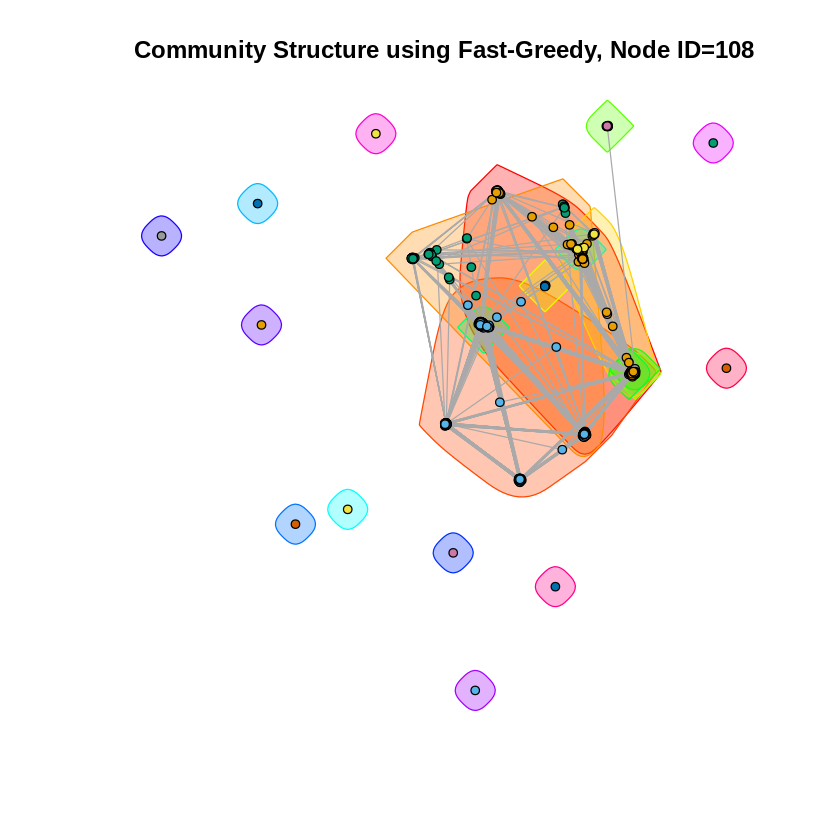

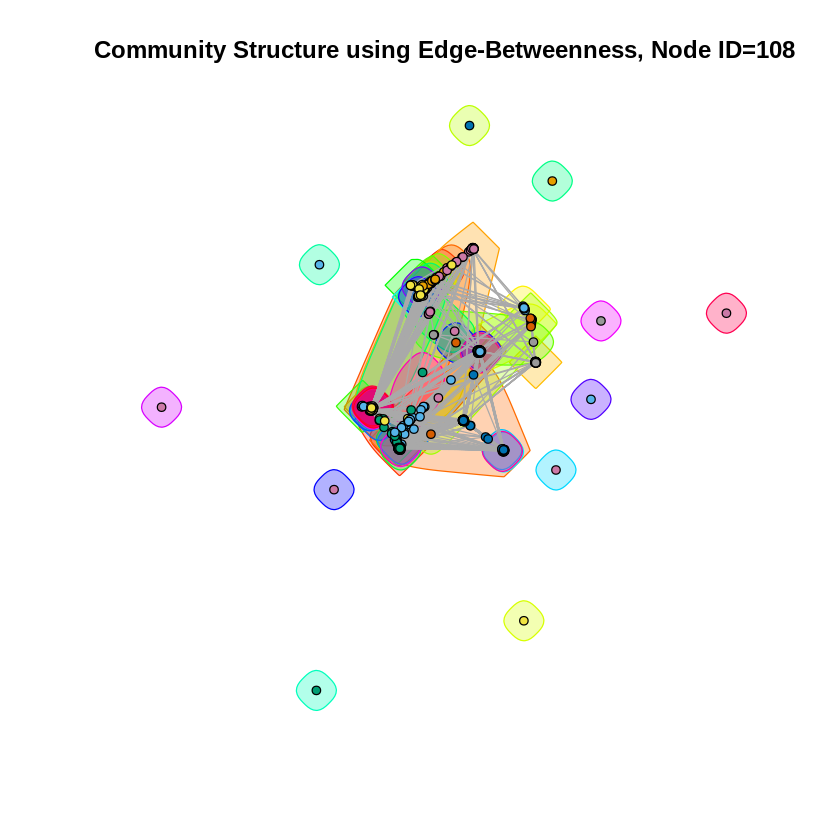

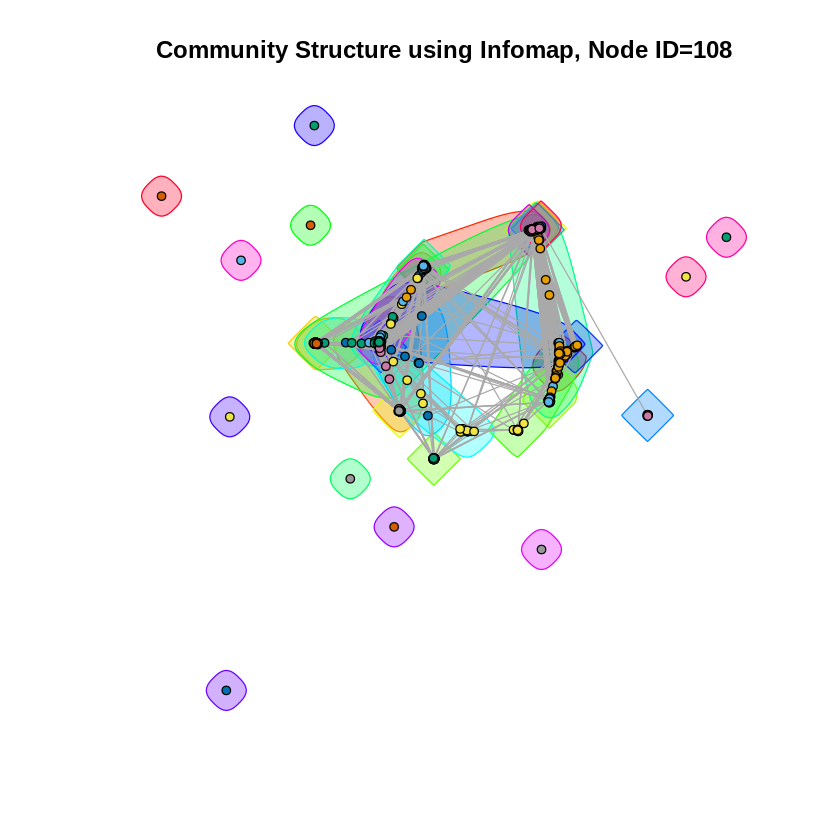

In [ ]:
i = 2
pnc.out <- induced_subgraph(fbgraph, neighbors(fbgraph, core_nodes[i]))

fg_communities <- cluster_fast_greedy(pnc.out)
eb_communities <- cluster_edge_betweenness(pnc.out)
infomap_communities <- cluster_infomap(pnc.out)

print(paste("Node ID is:",i))
fg_modularity <- modularity(fg_communities)
eb_modularity <- modularity(eb_communities)
infomap_modularity <- modularity(infomap_communities)

print(paste("Fast-Greedy Modularity:", fg_modularity))
print(paste("Edge-Betweenness Modularity:", eb_modularity))
print(paste("Infomap Modularity:", infomap_modularity))

plot(fg_communities, pnc, edge.color='darkgrey', vertex.size=3, vertex.label=NA)
title(sprintf("Community Structure using Fast-Greedy, Node ID=%.0f", idx[i]))

plot(eb_communities, pnc, edge.color='darkgrey', vertex.size=3, vertex.label=NA)
title(sprintf("Community Structure using Edge-Betweenness, Node ID=%.0f", idx[i]))

plot(infomap_communities, pnc, edge.color='darkgrey', vertex.size=3, vertex.label=NA)
title(sprintf("Community Structure using Infomap, Node ID=%.0f", idx[i]))

In [ ]:
# Dispersion function
disper <- function(personalized_graph, core, curr) {
    # Calculate dispertion in a personalized graph
    
    dis <- 0
    # If 
    if (degree(personalized_graph, curr) < 2) {
        return(0)
    }
    else {
        # get all friends exeept core
        mutual_friends <- neighbors(personalized_graph, curr)[-which(neighbors(personalized_graph, curr)$name==core)]
        mutual_friends <- as.numeric(mutual_friends$name)
        # remove two nodes: curr and core
        removed_graph <- induced_subgraph(personalized_graph,
                                        V(personalized_graph)[-c(which(V(personalized_graph)$name==core),curr)])
        
        num <- length(mutual_friends)
        for (i in 1:(num-1)) {
            for (j in (i+1):num) {
                
                dis <- dis + as.numeric(distances(
                        removed_graph,which(V(removed_graph)$name==mutual_friends[i]),which(V(removed_graph)$name==mutual_friends[j]))) 
                
            }
        }
        return (dis)
    }
}

In [ ]:
i = 108
network_for_108 <- induced_subgraph(fbgraph, c(i, neighbors(fbgraph,i)))
V(network_for_108)$name <- sort(c(i, neighbors(fbgraph,i)))

disper_108 <- c()
disper_name_108 <- c()
for (node in 1:vcount(network_for_108)) {
    if (V(network_for_108)[node]$name != 108) {
        disper_108 <- c(disper_108, disper(network_for_108,108, node))
        disper_name_108 <- c(disper_name_108, V(network_for_108)[node]$name)
    }
}

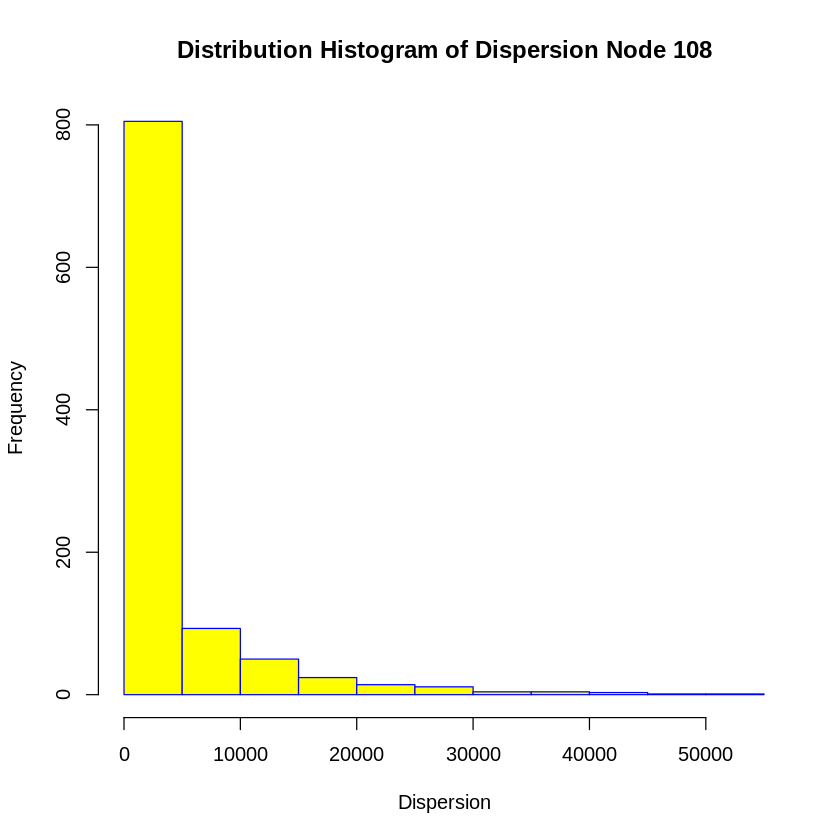

In [ ]:
hist(disper_108,main="Distribution Histogram of Dispersion Node 108",xlab="Dispersion",ylab="Frequency",col="yellow", border="blue")